# Goal: Create machine learning model that will predict quality of the wheat 

# Roadmap:


![Mapa](../images/map.jpeg)

## Loading libraries:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.preprocessing import LabelEncoder

## 1. Raw data gathering

In [2]:
#dataset from: https://www.kaggle.com/datasets/muratkokludataset/durum-wheat-dataset/data
path = "/home/darko/Desktop/durum_wheat/durum_wheat_ml/Durum_Wheat_Dataset/Dataset3-Durum Wheat Features/Durum Wheat Features.xlsx"

try:
    df = pd.read_excel(path, sheet_name=0)
    print(df.head())
except Exception as e:
    print(f"An unexpected error occurred: {e}")

     Target  AREA   MAJORAXIS  MINORAXIS  ECCENTRICITY     EQDIASQ  \
0  Vitreous   168  109.576157  39.396721      0.973060  213.904236   
1  Vitreous   162  105.584457  43.366894      0.964173  206.264801   
2  Vitreous   145   97.360207  35.532028      0.903072  184.619720   
3  Vitreous   178  104.080582  49.040062      1.272657  226.636627   
4  Vitreous   187  103.716667  40.885876     -1.469139  238.095779   

    PERIMETER  SOLIDITY  ROUNDNESS  SHAPEFACTOR  ...  Gabor_Y9(XYZ)  \
0  202.794052  0.087454   0.017815     0.051334  ...       1.187631   
1  194.794052  0.081901   0.018502     0.053650  ...       2.437782   
2  177.722961  0.096026   0.019477     0.057689  ...       0.527286   
3  202.509750  0.080507   0.020921     0.054543  ...       2.277434   
4  198.811234  0.097650   0.022134     0.059452  ...       2.337524   

   Gabor_Z1(XYZ)  Gabor_Z2(XYZ)  Gabor_Z3(XYZ)  Gabor_Z4(XYZ)  Gabor_Z5(XYZ)  \
0       0.003489       0.013901       0.031153       0.003591       0.01

## 2. EDA

In [3]:
print("Dataset shape (rows, columns):", df.shape)
print('*' * 40)

print("\nDataset info:")
df.info()
print('*' * 40)


df.describe()

print('*' * 40)

print("Missing values per column:")
print(df.isna().sum())

print('*' * 40)
print("Number of duplicate rows:", df.duplicated().sum())

print('*' * 40)
sample = df.sample(random_state=42, n=5)
print("Random sample of 5 rows:\n", sample)


Dataset shape (rows, columns): (9000, 237)
****************************************

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Columns: 237 entries, Target to Gabor_Z9(XYZ)
dtypes: float64(235), int64(1), object(1)
memory usage: 16.3+ MB
****************************************
****************************************
Missing values per column:
Target           0
AREA             0
MAJORAXIS        0
MINORAXIS        0
ECCENTRICITY     0
                ..
Gabor_Z5(XYZ)    0
Gabor_Z6(XYZ)    0
Gabor_Z7(XYZ)    0
Gabor_Z8(XYZ)    0
Gabor_Z9(XYZ)    0
Length: 237, dtype: int64
****************************************
Number of duplicate rows: 0
****************************************
Random sample of 5 rows:
         Target  AREA   MAJORAXIS  MINORAXIS  ECCENTRICITY     EQDIASQ  \
7940   Foreign   113   72.095627  31.201622      0.606692  143.876068   
1162  Vitreous   154  101.589783  38.577065      0.906564  196.078888   
582   Vitreous   

## Columns explained:

### **Target: main variable indicating wheat quality**
### - 'Vitreous' : high-quality, hard durum wheat
### - 'Starchy'  : softer wheat
### - 'Foreign'  : non-durum or defective grains

### Morphological features (shape and size):
### - AREA        : surface area of the grain
### - MAJORAXIS   : length of the major axis
### - MINORAXIS   : length of the minor axis
### - ECCENTRICITY: measure of how elongated the grain is (0 = circle, 1 = line)
### - PERIMETER   : perimeter of the grain
### - ROUNDNESS   : roundness measure
### - SOLIDITY    : compactness of the grain shape
### - SHAPEFACTOR : general shape descriptor
### - EQDIASQ     : equivalent diameter squared (derived from AREA)

### Textural features (from Gabor filters on images):
### - Gabor_X1(XYZ) … Gabor_X9(XYZ) : horizontal/vertical orientation texture descriptors
### - Gabor_Y1(XYZ) … Gabor_Y9(XYZ) : diagonal texture descriptors
### - Gabor_Z1(XYZ) … Gabor_Z9(XYZ) : high-frequency/energy texture descriptors

### Notes:
### - All numerical features can be used for ML models
### - Target is categorical; use LabelEncoder or one-hot encoding
### - Gabor features help capture subtle differences in surface texture, important for distinguishing wheat quality


### Category count

In [4]:
category_counts = df['Target'].value_counts()

print("Category distribution (counts):")
print(category_counts)

Category distribution (counts):
Target
Vitreous    3000
Starchy     3000
Foreign     3000
Name: count, dtype: int64


### Category visualisation

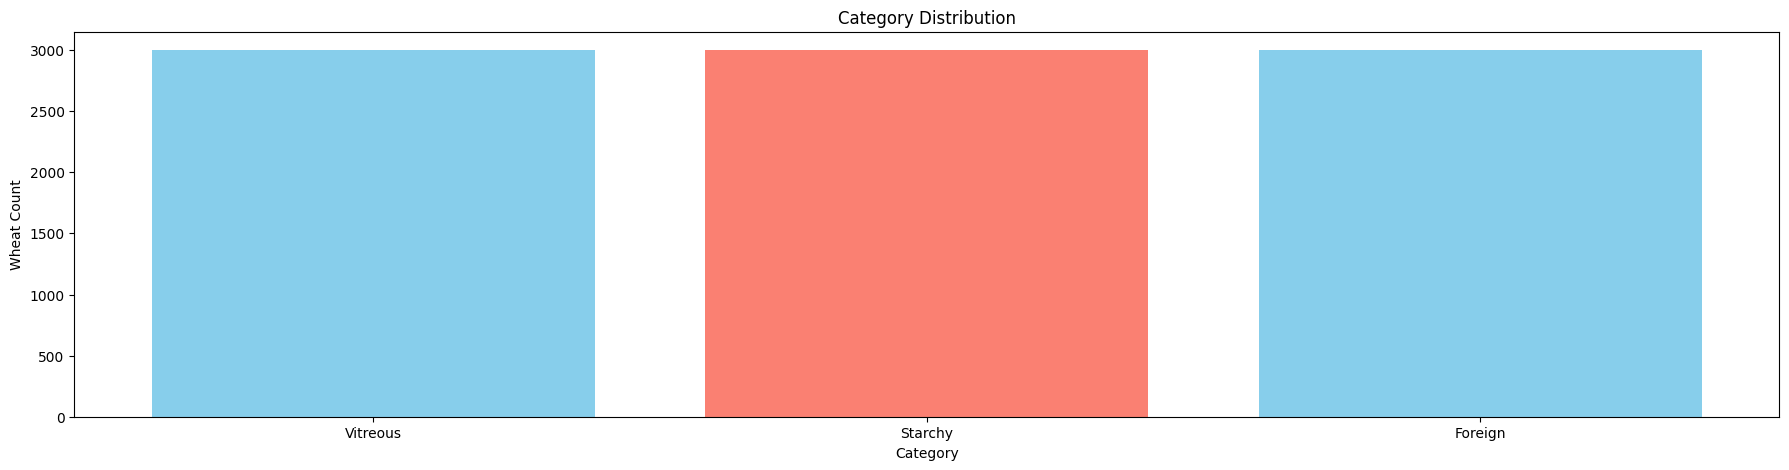

In [5]:
plt.figure(figsize=(22, 5))
plt.bar(category_counts.index, category_counts.values, color=['skyblue', 'salmon'])
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Wheat Count")
plt.show()

## 3. Data processing (cleaning)

In [6]:
def standardize_data(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    return df

def prepare_data(df):
    return standardize_data(df)

### Data after cleaning:

In [7]:
df = prepare_data(df)

print(df.dtypes)



target           object
area              int64
majoraxis       float64
minoraxis       float64
eccentricity    float64
                 ...   
gabor_z5xyz     float64
gabor_z6xyz     float64
gabor_z7xyz     float64
gabor_z8xyz     float64
gabor_z9xyz     float64
Length: 237, dtype: object


## 4. Feature engineering

### Deciding which columns are relevant for our future model...

In [8]:
le = LabelEncoder()
df['target_encoded'] = le.fit_transform(df['target'])

correlations = df.corr(numeric_only=True)['target_encoded'].sort_values(ascending=False)
print(correlations)



target_encoded    1.000000
gabor_a*3         0.774117
gabor_a*2         0.773761
gabor_a*1         0.773103
mean_a*           0.772723
                    ...   
gabor_b6         -0.727447
mean_b           -0.729039
gabor_b1         -0.729089
gabor_b2         -0.729253
gabor_b3         -0.729451
Name: target_encoded, Length: 237, dtype: float64


### Separating important columns (with correlation more than 0.3) 

In [9]:
important_features = correlations[correlations.abs() > 0.3].index.tolist()

print("Important features based on correlation threshold:\n", important_features)

important_features_without_column_target = [f for f in important_features if f != 'target_encoded']

print('Number of columns in important_features_without_column_target:', len(important_features_without_column_target))

Important features based on correlation threshold:
 ['target_encoded', 'gabor_a*3', 'gabor_a*2', 'gabor_a*1', 'mean_a*', 'gabor_a*6', 'gabor_a*4', 'gabor_a*5', 'db4_a*', 'gabor_cr3', 'gabor_cr2', 'gabor_cr1', 'mean_cr', 'gabor_cr6', 'gabor_cr5', 'gabor_cr4', 'db4_cr', 'skew_v', 'skew_r', 'skew_l', 'skew_g', 'skew_y', 'skew_yxyz', 'mean_s', 'gabor_s1', 'gabor_s2', 'gabor_s3', 'gabor_s5', 'gabor_s6', 'gabor_s4', 'skew_xxyz', 'db4_s', 'entropy_s', 'entropy_v', 'entropy_b', 'skew_zxyz', 'skew_b', 'skew_b*', 'entropy_g', 'kurtosis_yxyz', 'kurtosis_xxyz', 'stddev_s', 'entropyl', 'entropy_y', 'minoraxis', 'db4_b*', 'mean_b*', 'gabor_b*1', 'gabor_b*6', 'gabor_b*5', 'gabor_b*2', 'gabor_b*3', 'gabor_b*4', 'majoraxis', 'kurtosis_zxyz', 'perimeter', 'entropy_r', 'eqdiasq', 'area', 'gabor_x8xyz', 'gabor_cb3', 'gabor_cb2', 'gabor_cb1', 'roundness', 'mean_cb', 'entropy_yxyz', 'db4_cb', 'stddev_cb', 'gabor_y8xyz', 'gabor_x7xyz', 'gabor_cb5', 'gabor_cb4', 'gabor_cb6', 'gabor_cr7', 'gabor_y7xyz', 'gabor

## 5: Algorithm selection:

In [10]:
X = df[important_features_without_column_target] 
y = df["target_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Model selection

In [11]:
numeric_features = X_train.columns.tolist()
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_features)
])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": LinearSVC(max_iter=10000)
}

for name, model in models.items():
    print(f"\nModel: {name}")

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
    print(classification_report(y_test, y_pred))


Model: Logistic Regression


Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       600
           1       0.95      0.94      0.95       600
           2       0.94      0.96      0.95       600

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800


Model: Naive Bayes
Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       600
           1       0.88      0.73      0.80       600
           2       0.79      0.95      0.86       600

    accuracy                           0.87      1800
   macro avg       0.88      0.87      0.87      1800
weighted avg       0.88      0.87      0.87      1800


Model: Decision Tree
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       600
           1       0.98      0.95      0.9

## Winner is Random Forest (Accuracy 0.99)


## 6. Model training

In [12]:
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("Random Forest", RandomForestClassifier())
])



pipeline.fit(X, y)

joblib.dump(pipeline, "../model/wheat_sorting.pkl")

print(" Model trained and saved as 'model/wheat_sorting.pkl'")


 Model trained and saved as 'model/wheat_sorting.pkl'


## 7. Model testing:

In [15]:
n_samples = 5  

test_df = pd.DataFrame(
    np.random.rand(n_samples, X_train.shape[1]) * 100,  
    columns=X_train.columns
)

predictions = pipeline.predict(test_df)

predicted_labels = le.inverse_transform(predictions)

# Prikaz rezultata
print("Test samples:\n", test_df.head())
print("\nPredicted wheat quality:\n", predicted_labels)


Test samples:
    gabor_a*3  gabor_a*2  gabor_a*1    mean_a*  gabor_a*6  gabor_a*4  \
0  18.807395  79.103037   7.982325  54.600536  62.992982  53.693457   
1  72.333991  13.344556   8.692794  56.281361  38.393546   8.534602   
2   0.262963  95.831198  54.737749  94.508253  54.024845  93.677031   
3  28.463300  77.571470  19.528751  84.624257  44.567241  20.248151   
4  91.269872   2.820933  98.469592  69.223971  29.314132  30.136178   

   gabor_a*5     db4_a*  gabor_cr3  gabor_cr2  ...   gabor_g5   gabor_g6  \
0  31.483925  24.057640  80.509177  10.648369  ...  97.097530   3.390181   
1  98.828300   1.118506  38.563131  23.163078  ...  52.155998  44.393741   
2  79.057352  28.311180  16.185022  66.309305  ...  44.849881  43.302500   
3   9.795285  58.482125   0.770230  87.915045  ...  51.267018  28.327253   
4  85.879433  77.698837  12.998159  62.197095  ...  31.437740  65.929588   

       db4_b   gabor_b4   gabor_b5   gabor_b6     mean_b   gabor_b1  \
0  61.673019  98.608413  18.02

## 8. Model exporting: